In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import PIL
import pathlib
import os
import time
import imageio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from IPython import display
%matplotlib inline

In [2]:
# fetch data
path = '../abstract_art_512'
data_dir = pathlib.Path(path)

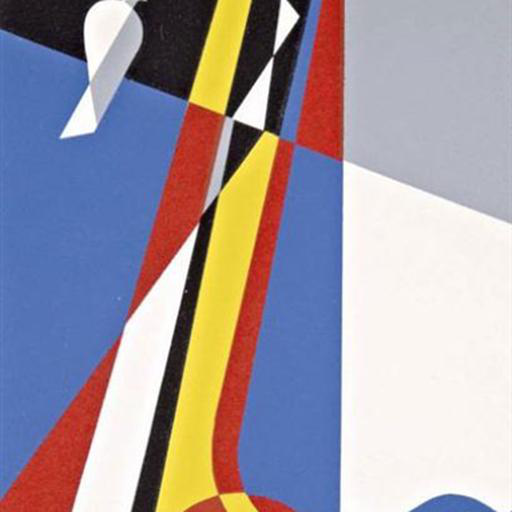

In [3]:
# visualize one image
test_img = list(data_dir.glob('abstract_yves-laloy_7236.jpg'))
PIL.Image.open(str(test_img[0]))

In [4]:
# image read parameters
seed = 1337
batch_size = 64
img_height = 64
img_width = 64

In [5]:
# read images as a tf object
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels=None,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8145 files belonging to 1 classes.


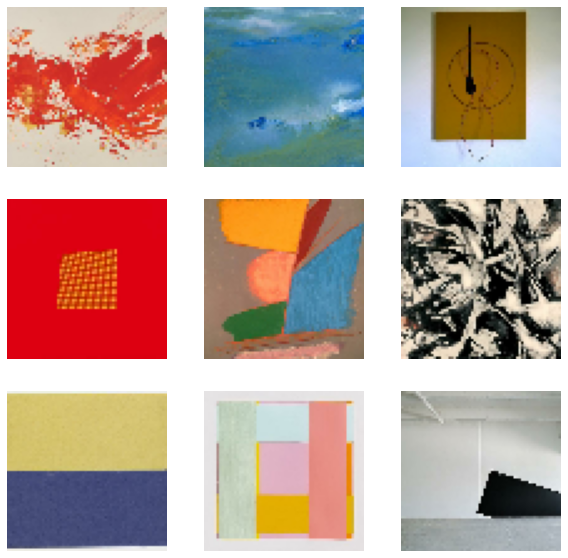

In [6]:
# visualize + randomly selected images
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')

In [7]:
# standardize data to [-1, 1]
normalization = tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: (normalization(x)))

In [8]:
# validate the transformation
image_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

-0.93921566 0.8725492


In [9]:
# check dimensions
image_batch[0].shape

TensorShape([64, 64, 3])

In [10]:
# prefetch data for training performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds_ = normalized_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
def make_generator_model():
    model = tf.keras.Sequential(name='generator')
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [12]:
# validate output shape
generator = make_generator_model()
print(generator.layers[-1].output_shape)

(None, 64, 64, 3)


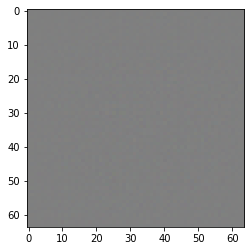

In [13]:
# test to generate an "untrained" image
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow((generated_image.numpy()[0] * 127.5 + 127.5).astype('uint8'))
plt.show()

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential(name='discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
   
    return model

In [15]:
# create and test discriminator
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00173181]], shape=(1, 1), dtype=float32)


In [16]:
# define loss functions for G and D
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [17]:
# define optimizers 
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [18]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  plt.figure(figsize=(8, 8))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('plots/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [19]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, d_loss, g_loss):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss = d_loss
        self.g_loss = g_loss

    def train_step(self, images):
        batch_size = tf.shape(images)[0]
        noise = tf.random.normal([batch_size, self.latent_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            gen_loss = self.g_loss(fake_output)
            disc_loss = self.d_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            gen_loss, self.generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            disc_loss, self.discriminator.trainable_variables
        )

        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, self.generator.trainable_variables)
        )
        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables)
        )

        return {'disc_loss': disc_loss, 'gen_loss': gen_loss}

In [20]:
# define callbacks 
early_stopping = callbacks.EarlyStopping(
    monitor='gen_loss', min_delta=0, patience=5, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

checkpoints = callbacks.ModelCheckpoint(
    filepath=os.path.join(os.getcwd(), 'ckpt', 'best_weights'),
    monitor='gen_loss',
    save_weights_only=True,
    save_best_only=True
)

In [21]:
# training params
EPOCHS = 50
LATENT_DIM = 100

In [23]:
# create, compile and train model
gan = GAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=LATENT_DIM
)

gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    d_loss=discriminator_loss,
    g_loss=generator_loss
)

history = gan.fit(
    train_ds_,
    epochs=EPOCHS,
    callbacks=[checkpoints],
    shuffle=True
)

Epoch 1/50
128/128 [==============================] - 73s 562ms/step - disc_loss: 0.4585 - gen_loss: 2.8407
Epoch 2/50
128/128 [==============================] - 73s 573ms/step - disc_loss: 0.3052 - gen_loss: 2.9894
Epoch 3/50
128/128 [==============================] - 71s 550ms/step - disc_loss: 0.4224 - gen_loss: 3.0692
Epoch 4/50
128/128 [==============================] - 74s 578ms/step - disc_loss: 0.2934 - gen_loss: 3.2694
Epoch 5/50
128/128 [==============================] - 67s 525ms/step - disc_loss: 0.7408 - gen_loss: 2.4641
Epoch 6/50
128/128 [==============================] - 69s 539ms/step - disc_loss: 0.6551 - gen_loss: 2.0528
Epoch 7/50
128/128 [==============================] - 69s 542ms/step - disc_loss: 0.3898 - gen_loss: 2.5185
Epoch 8/50
128/128 [==============================] - 68s 534ms/step - disc_loss: 0.5291 - gen_loss: 2.6213
Epoch 9/50
128/128 [==============================] - 69s 537ms/step - disc_loss: 0.7702 - gen_loss: 1.8748
Epoch 10/50
128/128 [=======

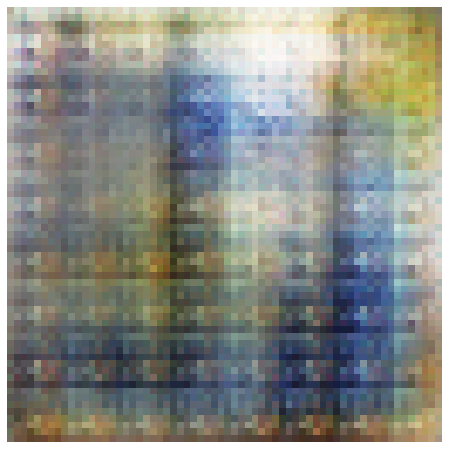

In [113]:
# test to generate an "untrained" image
noise = tf.random.normal([1, 100])
generated_image_test = gan.generator(noise, training=False)
plt.figure(figsize=(8, 8))
plt.imshow((generated_image_test.numpy()[0] * 127.5 + 127.5).astype('uint8'))
plt.axis('off')
plt.show()